In [498]:

import os
import numpy as np
import matplotlib.pyplot as plt
import re

path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-07\2024-07-24_11-09-09test_Homodyne.txt"

In [499]:
def get_paths_homodyne(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "Homodyne" in e]

def get_paths_intensity(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "intensity" in e]

def get_OSA_paths(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "OSA" in e]


def get_data(path,length=1):

    return np.loadtxt(path, encoding = "unicode_escape",skiprows=1,delimiter=' ')

def plot_data(path,figure_no=1):

    header = get_header(path)[0]
    xs, ys = get_data(path)
    plt.figure(figure_no)
    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    

def ratio_to_db(ratio):

    return 10*np.log10(ratio)

def convert_optical_to_electrical(power):


    conversion = 307.4*1e-3/104.9 #V/µW

    volts = conversion*power #V

    elec_power = volts**2/50 #V^2/Ohm = W

    elec_power_mW = 1e3*elec_power #mW

    power_sq_dBm = 20*np.log10(elec_power_mW/1) # 10*log10( [P/1mW]^2 ) [dBm]
    
    return power_sq_dBm


def get_header(path,length=1):
    lines = []
    with open(path,encoding="ISO-8859-1") as file:
        for i in range(length):
            line = file.readline()
            lines.append(line[1:].split(','))
    return lines

def plot_OSA_data(directory):

    plt.figure()

    paths = get_OSA_paths(directory)

    peak_wavelengths = [0 for _ in paths]
    gain = [0 for _ in paths]
    fb_level = [0 for _ in paths]

    for i, path in enumerate(paths):

        header = get_header(path,length=4)

        peak_wavelengths[i] = float(header[0][0].split(" ")[3])

        gain_fb_list = header[3][0].split("_")

        if len(gain_fb_list) < 2:

            gain_fb_list = header[3][0].split(" ")
            
            gain[i] = float(gain_fb_list[1])

            fb_level[i] = 0

        else:

            gain[i] = float(gain_fb_list[0])

            if i in range(4,8):
                fb_level[i] = float(gain_fb_list[2][:-3])

            else:
                fb_level[i] = float(gain_fb_list[2][:-2])

        if gain[i] == 40:
    
            plt.plot(peak_wavelengths[i],fb_level[i],'b.')

        elif gain[i] == 60:
    
            plt.plot(peak_wavelengths[i],fb_level[i],'r.')

        elif gain[i] == 80:
    
            plt.plot(peak_wavelengths[i],fb_level[i],'g.')

        elif gain[i] == 110:
    
            plt.plot(peak_wavelengths[i],fb_level[i],'k.')

        print(gain_fb_list)


def plot_rel_osc_data(directory):
    plt.figure()
    paths = get_paths_homodyne(directory)[8:11]

    for i,path in enumerate(paths):

        header = get_header(path)[0]
        xs, ys = get_data(path)
        plt.plot(xs*1e-9,ys-max(ys),alpha=1-i/5)

        # if len(header)>3:
        #     plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
        # else:
        #     plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    plt.ylabel('Contrast [dB]')
    plt.legend(['Pol.: Coherent peak height', 'Pol.: Relaxation oscillation peak height', 'Pol.: Moved and broad relaxaction oscillation'])
    plt.xlim(0,5)
    plt.savefig(r'./Rel_osc_freq_DSH.pdf')
    plt.savefig(r'./Rel_osc_freq_DSH.png')

def plot_int_data(figure_no):

    plt.figure(figure_no)
    header = get_header(path,length=1)[0]
    xs, ys = get_data(path)

    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')


def plot_intensity_data(directory):

    paths = get_paths_intensity(directory)

    fb_counter = [0,0,0,0,0,0,0,0]

    rbw = 0.5*1e6 #500 kHz

    rbw_db = 10*np.log10(rbw)

    no_fb_rel_osc = [0,0,0,0]

    for i, path in enumerate(paths):

        header = get_header(path,length=1)[0]

        fb_level = float(header[1].split(" ")[3][:-2])
        
        if i <8:
            gain = header[2][1:-1]
        else:
            gain = header[2][1:]

        power = float(header[0].split(" ")[1][:-2])

        fb_dB = ratio_to_db(fb_level/(power*40))


        if fb_level < 1*0.2:

            plt.figure(2)
            
            xs, ys = get_data(path)

            ys += -convert_optical_to_electrical(power) - rbw_db

            plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40:.0f}µW, ' + f'fb: {fb_dB:.1f} dB', alpha=1-fb_counter[0]/10)


            if gain == 'Gain: 40mA':

                index = np.where(ys==np.max(ys[10:-20000]))

                no_fb_rel_osc[fb_counter[0]] = xs[index][0]
                print(f'Between {xs[10]*1e-9:.4f} and {xs[-20000]*1e-9:.2f} GHz')

            else:

                index = np.where(ys==np.max(ys[15000:-20000]))

                no_fb_rel_osc[fb_counter[0]] = xs[np.where(ys==np.max(ys[15000:-20000]))][0]

                print(f'Between {xs[15000]*1e-9:.2f} and {xs[-20000]*1e-9:.2f} GHz')

                

            print(gain, ys[index])

            print(f'Rel. osc.: {no_fb_rel_osc[fb_counter[0]]*1e-9:.2f} GHz\n')

            #plt.axvline(x=no_fb_rel_osc[fb_counter[0]]*1e-9, color = 'b', label = '_nolegend_')

            fb_counter[0] +=1


        elif fb_level<10*0.2:

            plt.figure(3)
            
            xs, ys = get_data(path)

            ys += -convert_optical_to_electrical(power) - rbw_db


            plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40:.0f}µW, ' + f'fb: {fb_dB:.1f} dB', alpha=1-fb_counter[1]/10)


            fb_counter[1] +=1


        elif fb_level<100*0.2:
          
            xs, ys = get_data(path)

            ys += -convert_optical_to_electrical(power) - rbw_db


            if "height" in header[3][:-1]:

                plt.figure(4)

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + header[3][:-1], alpha=1-fb_counter[2]/10)
                
                fb_counter[2] +=1


            else: 

                plt.figure(5)

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + header[3][:-1], alpha=1-fb_counter[3]/10)

                fb_counter[3] +=1



        elif fb_level < 920*0.2:
            
            
            xs, ys = get_data(path)

            ys += -convert_optical_to_electrical(power) - rbw_db

            if "bad" in header[3][:-1]:

                plt.figure(6)

                if fb_counter[4] == 0:
                    pass
                else:
                    plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40:.0f}µW, ' + f'fb: {fb_dB:.1f} dB', alpha=1-(fb_counter[4]-1)/10)

                fb_counter[4] +=1

            
            else: 

                plt.figure(7)


                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40:.0f}µW, ' + f'fb: {fb_dB:.1f} dB', alpha=1-fb_counter[5]/10)


                if gain == 'Gain: 40mA':

                    rel_osc = xs[np.where(ys==np.max(ys[10:-20000]))][0]
                    print(f'Between {xs[10]*1e-9:.4f} and {xs[-20000]*1e-9:.2f} GHz')

                else:

                    rel_osc = xs[np.where(ys==np.max(ys[15000:-20000]))][0]

                    print(f'Between {xs[15000]*1e-9:.2f} and {xs[-20000]*1e-9:.2f} GHz')

                    

                print(gain)

                print(f'100µW fb, Rel. osc.: {rel_osc*1e-9:.2f} GHz \n')

                #plt.axvline(x=rel_osc*1e-9, color = 'b', label = '_nolegend_')




                

            fb_counter[5] +=1

            


        elif fb_level >= 920*0.2:
            
            xs, ys = get_data(path)

            ys += -convert_optical_to_electrical(power) - rbw_db

            if "bad" in header[3][:-1]:

                if fb_counter[6] % 2 == 0:
                    plt.figure(8)

                    plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + header[3][:-1], alpha=1-fb_counter[6]/20)

                else:
                    plt.figure(9)

                    plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + header[3][:-1], alpha=1-fb_counter[6]/20)


                fb_counter[6] +=1

            
            else: 

                plt.figure(10)


                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power*40}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + header[3][:-1], alpha=1-fb_counter[7]/10)

                fb_counter[7] +=1



    list_fb = ['None','1µW','10µW, bad coherence', '10µW, good coherence','100µW bad coherence','100µW good coherence','920µW bad coherence','920µW bad coherence 2', '920µW good coherence']
    save_path = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\Measurement spectra and plots\RIN"
    for i in range(9):
        plt.figure(i+2)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        plt.legend()
        plt.xlabel('freq, f [GHz]')
        plt.ylabel('RIN [dBc/Hz]')
        plt.ylim([-160,-75])
        plt.xlim([0,10])

        
        plt.savefig(fr'{save_path}\RIN_gain_fb_{list_fb[i]}.pdf')
        plt.savefig(fr'{save_path}\RIN_gain_fb{list_fb[i]}.png')

In [500]:
directory = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-07"

paths_homodyne = get_paths_homodyne(directory)
print(len(paths_homodyne))

paths_intensity = get_paths_intensity(directory)
print(len(paths_intensity))

14
36


['', '40', 'gain', 'no', 'feedback\n']
['', '60', 'gain', 'no', 'feedback\n']
['', '80', 'gain', 'no', 'feedback\n']
['', '110', 'gain', 'no', 'feedback\n']
[' 110', 'Gain', '100ÂµW', 'fb', 'coh', 'pol\n']
[' 110', 'Gain', '100ÂµW', 'fb', 'bad', 'pol\n']
[' 110', 'Gain', '100ÂµW', 'fb', 'bad', 'pol2\n']
[' 80', 'Gain', '80ÂµW', 'fb', 'coh', 'pol\n']
[' 80', 'Gain', '80µW', 'fb', 'bad', 'pol\n']
[' 60', 'Gain', '62µW', 'fb', 'coh', 'pol\n']
[' 60', 'Gain', '63µW', 'fb', 'bad', 'pol\n']
[' 40', 'Gain', '33.5µW', 'fb', 'coh', 'pol?\n']
[' 40', 'Gain', '37.1µW', 'fb', 'bad', 'pol? trying to maximize RIN\n']
[' 110', 'Gain', '922µW', 'fb', 'coh', 'pol\n']
[' 110', 'Gain', '919µW', 'fb', 'semibad', 'pol\n']
[' 110', 'Gain', '917µW', 'fb', 'bad', 'pol\n']
[' 80', 'Gain', '763µW', 'fb', 'coh', 'pol\n']
[' 80', 'Gain', '738µW', 'fb', 'cbad', 'pol\n']
[' 80', 'Gain', '734µW', 'fb', 'semibad', 'pol\n']
[' 60', 'Gain', '552µW', 'fb', 'coh', 'pol\n']
[' 60', 'Gain', '571µW', 'fb', 'bad', 'pol multi

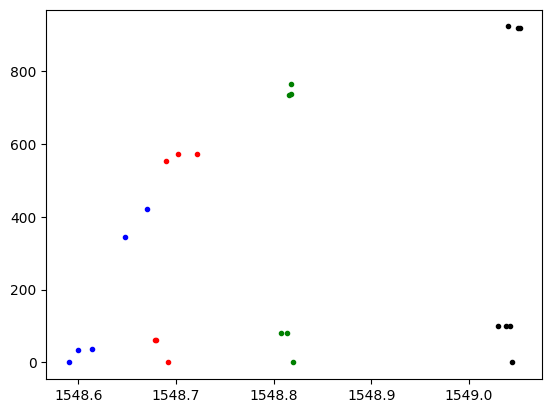

In [501]:
plot_OSA_data(directory)

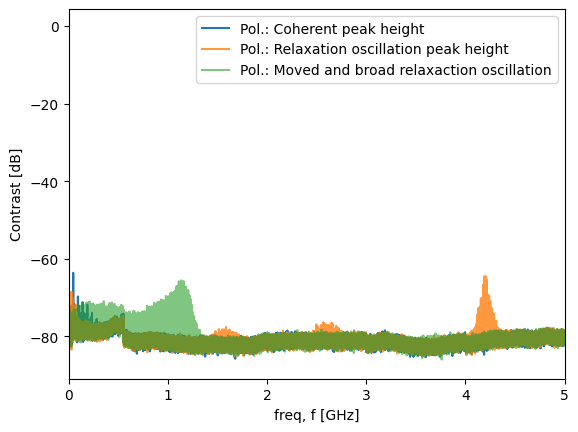

In [502]:
plot_rel_osc_data(directory)

Between 1.50 and 8.00 GHz
Gain: 110mA [-149.13719584]
Rel. osc.: 5.66 GHz

Between 1.50 and 8.00 GHz
Gain: 80mA [-143.67598609]
Rel. osc.: 3.68 GHz

Between 1.50 and 8.00 GHz
Gain: 60mA [-135.20159369]
Rel. osc.: 2.57 GHz

Between 0.0010 and 8.00 GHz
Gain: 40mA [-114.43400299]
Rel. osc.: 1.35 GHz

Between 1.50 and 8.00 GHz
Gain: 110mA
100µW fb, Rel. osc.: 4.94 GHz 

Between 1.50 and 8.00 GHz
Gain: 80mA
100µW fb, Rel. osc.: 3.68 GHz 

Between 1.50 and 8.00 GHz
Gain: 60mA
100µW fb, Rel. osc.: 2.77 GHz 

Between 0.0010 and 8.00 GHz
Gain: 40mA
100µW fb, Rel. osc.: 1.55 GHz 



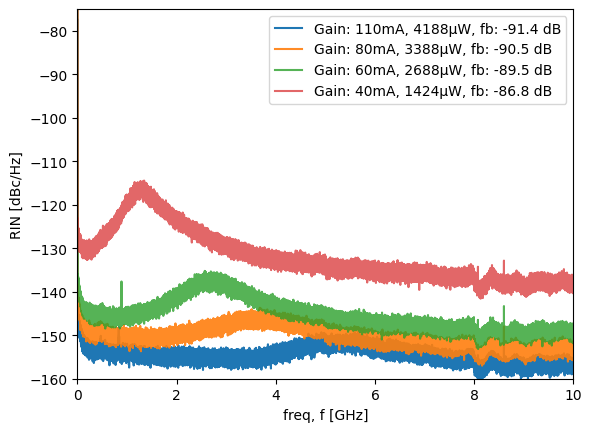

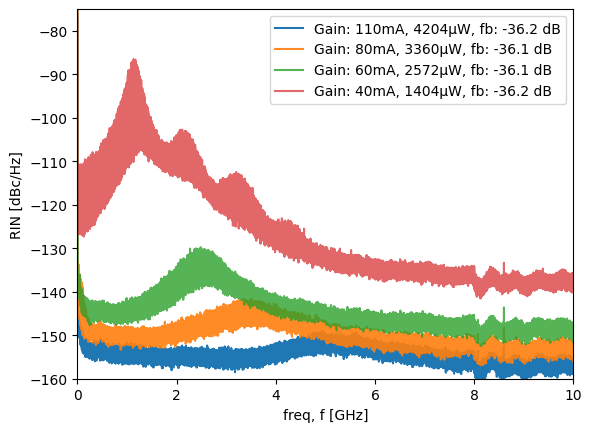

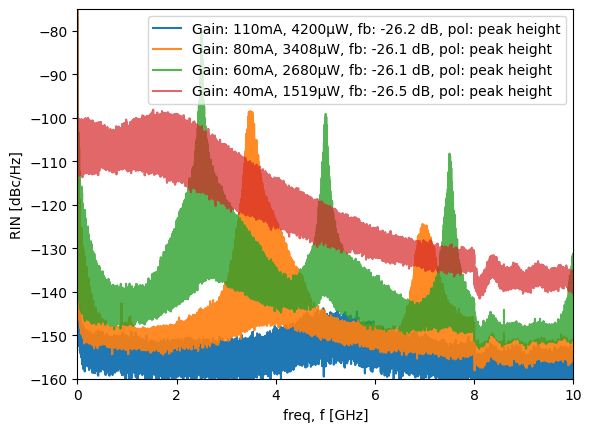

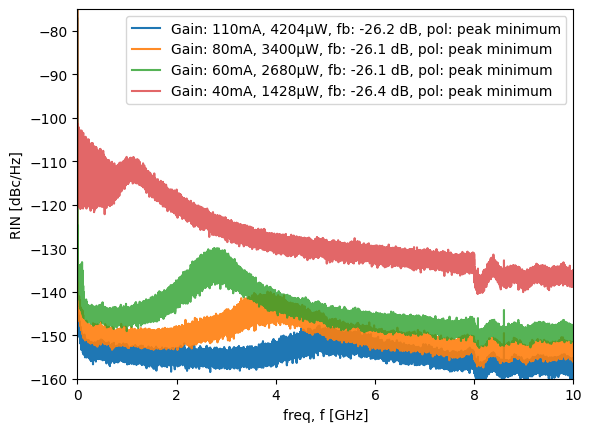

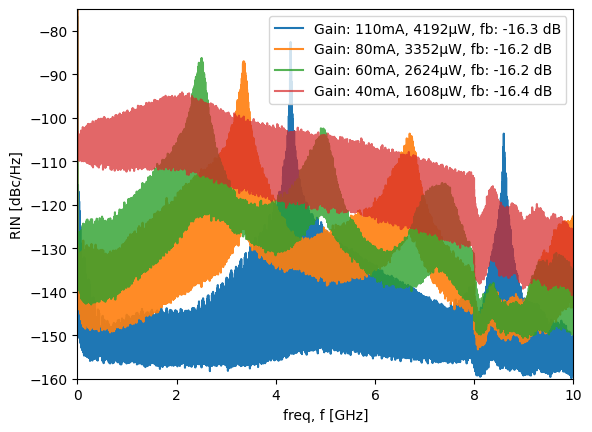

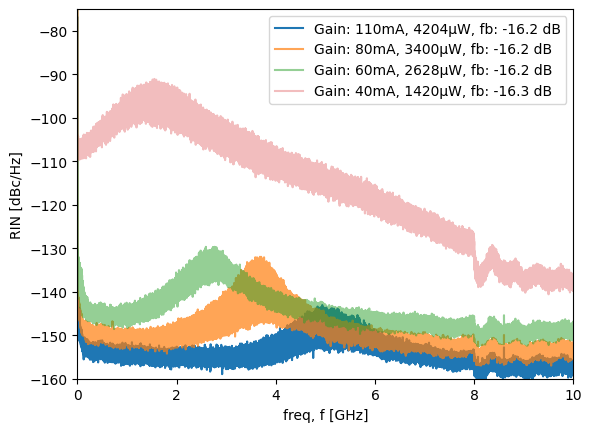

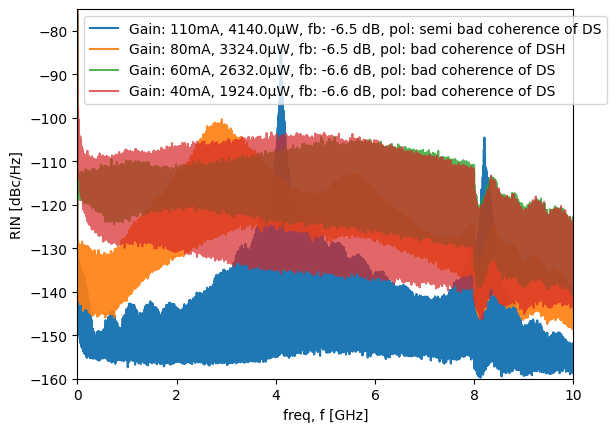

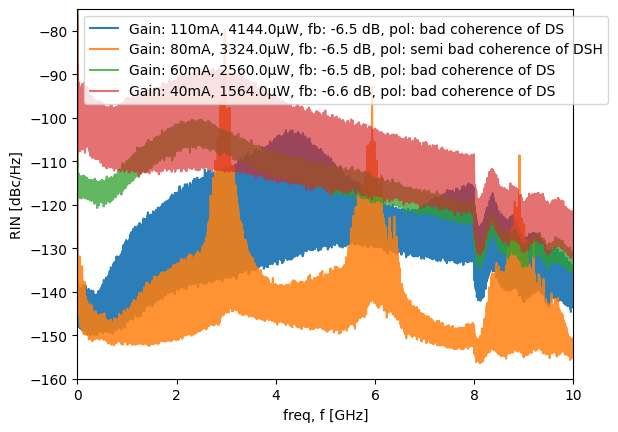

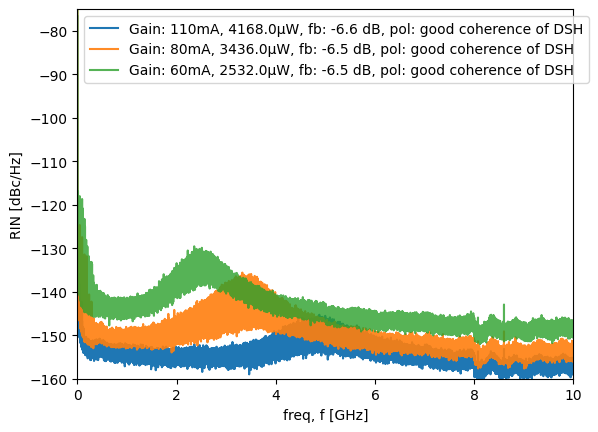

In [503]:
plot_intensity_data(directory)

In [504]:
get_header(paths_intensity[8])

[[' 105.1uW output', ' fb = 10.19uW', ' Gain: 110mA', ' pol: peak minimum\n']]

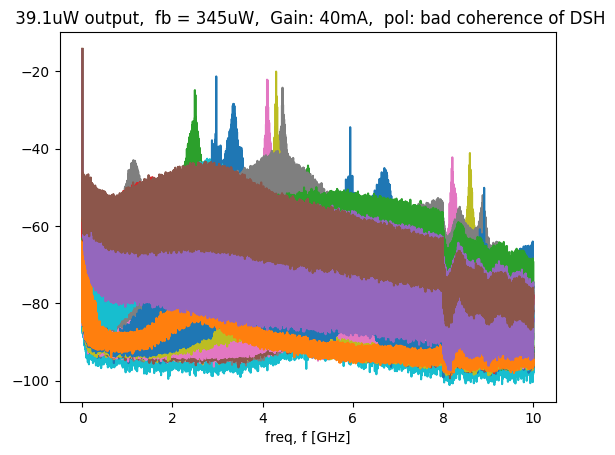

In [505]:
for i in range(36):
    
    plot_data(paths_intensity[i])

In [506]:
10**(80/10)*1e-9

0.1

In [507]:
np.sqrt(1/(10**(-149.13719584/10)/(16*np.pi*1e6)))*1e-9

202.99938382375043